# Import Module

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn import preprocessing

# Load Data

In [2]:
train = pd.read_csv("train.csv")
daikon = train[train.kind == "だいこん"].sort_values("date").mode_price.values

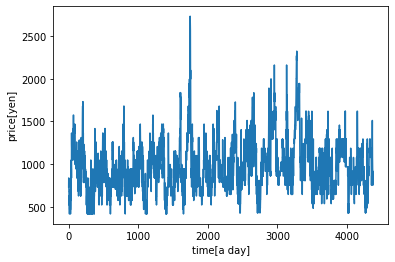

In [3]:
plt.xlabel("time[a day]")
plt.ylabel("price[yen]")
plt.plot(daikon)

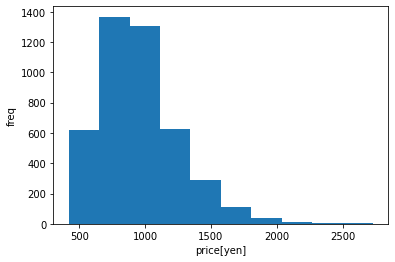

In [4]:
plt.xlabel("price[yen]")
plt.ylabel("freq")
plt.hist(daikon)
plt.show()

# Preprocessing

In [5]:
train_size = 4000
train = daikon[:train_size].reshape(-1, 1)
test = daikon[train_size:].reshape(-1, 1)

ss = preprocessing.StandardScaler()
ss.fit(train)
train = ss.transform(train)
test = ss.transform(test)

T = 10
train_N = train.shape[0] // 10
test_N = test.shape[0] // 10
train = train[:train_N * T]
test = test[:test_N * T]

train = train.reshape(train_N, T, 1)
train_x = train[:, :-1, :]
train_y = train[:, 1:, :]
test = test.reshape(test_N, T, 1)
test_x = test[:, :-1, :]
test_y = test[:, 1:, :]

In [6]:
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# Build Model

In [7]:
class rnn(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.rnn1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size, int(hidden_size/2), batch_first=True)
        self.fc = nn.Linear(int(hidden_size/2), output_size)

    def forward(self, x):
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = self.fc(out)
        return out

# Instantiate Model, Optimizer, Criterion

In [8]:
model = rnn()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

# Training and Test

In [9]:
num_epochs = 100
for epoch in range(num_epochs):
    
    # Training
    optimizer.zero_grad()
    out = model(train_x)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"training loss = {loss}")
    
    # Test
    with torch.no_grad():
        model.eval()
        pred_y = model(test_y)
        loss = criterion(pred_y, test_y)
        
        if epoch % 10 == 0:
            print(f"test loss = {loss}")

training loss = 1.0172864198684692
test loss = 0.7334558367729187
training loss = 0.5511326789855957
test loss = 0.32303744554519653
training loss = 0.4096645712852478
test loss = 0.18656884133815765
training loss = 0.29245781898498535
test loss = 0.09149762243032455
training loss = 0.24169009923934937
test loss = 0.04697746783494949
training loss = 0.2245866358280182
test loss = 0.03488003462553024
training loss = 0.2189018726348877
test loss = 0.027401786297559738
training loss = 0.21368344128131866
test loss = 0.027592701837420464
training loss = 0.20977993309497833
test loss = 0.02843182347714901
training loss = 0.20671020448207855
test loss = 0.027437882497906685


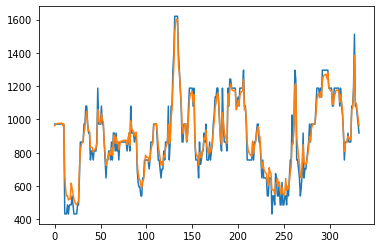

In [10]:
test_y = test_y.reshape(-1, 1)
test_y = ss.inverse_transform(test_y)
pred_y = pred_y.reshape(-1, 1)
pred_y = ss.inverse_transform(pred_y)

plt.plot(test_y, label="test")
plt.plot(pred_y, label="pred")